# Structured Data

## Problem 1

### Summary

* Create a positive set based on patients who have taken "Target Drug" and a negative set considering the time aspect, with features like prescription frequency and time intervals to predict eligibility 30 days in advance.

* Develop and evaluate the model on a validation set, focusing on strategies to minimize false positives and false negatives, ultimately prioritizing F1-Score as the evaluation metric.

* Apply the trained model to make predictions for patients in the test dataset, labeling them as 1 or 0 for eligibility, and submit the final predictions in a CSV file for assessment.

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
import warnings

In [2]:
#Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
#Loading dataset-  Train
train_df = pd.read_parquet("train.parquet")

In [4]:
#Fetching top 5 rows
train_df.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


In [5]:
#Fetching bottom 5 rows
train_df.tail()

,Patient-Uid,Date,Incident
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6
29080911,a0ee146e-1c7c-11ec-baee-16262ee38c7f,2018-10-05,DRUG_TYPE_1


In [6]:
#Analysing data
train_df.shape

(3220868, 3)

In [7]:
#Columns in the dataset
train_df.columns

Index(['Patient-Uid', 'Date', 'Incident'], dtype='object')

In [8]:
#Descriptive statistics
train_df.describe()

,Date
count,3220868
mean,2018-02-24 18:27:44.495410944
min,2015-04-07 00:00:00
25%,2016-11-30 00:00:00
50%,2018-04-11 00:00:00
75%,2019-05-30 00:00:00
max,2020-09-03 00:00:00


In [9]:
#Data Pre-Processing
#Missing Values
train_df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [10]:
#Remove duplicates
train_df = train_df.drop_duplicates()

In [11]:
#Checking for duplicate values
train_df.duplicated().sum()

0

In [12]:
#Data types
train_df.dtypes

Patient-Uid            object
Date           datetime64[ns]
Incident               object
dtype: object

In [13]:
#Unique values of incident column
print("Unique values of Incident \n")
print(train_df['Incident'].unique())

Unique values of Incident 

['PRIMARY_DIAGNOSIS' 'SYMPTOM_TYPE_0' 'DRUG_TYPE_0' 'DRUG_TYPE_1'
 'DRUG_TYPE_2' 'TEST_TYPE_0' 'DRUG_TYPE_3' 'DRUG_TYPE_4' 'DRUG_TYPE_5'
 'DRUG_TYPE_6' 'DRUG_TYPE_8' 'DRUG_TYPE_7' 'SYMPTOM_TYPE_1' 'DRUG_TYPE_10'
 'SYMPTOM_TYPE_29' 'SYMPTOM_TYPE_2' 'DRUG_TYPE_11' 'DRUG_TYPE_9'
 'DRUG_TYPE_13' 'SYMPTOM_TYPE_5' 'TEST_TYPE_1' 'SYMPTOM_TYPE_6'
 'TEST_TYPE_2' 'SYMPTOM_TYPE_3' 'SYMPTOM_TYPE_8' 'DRUG_TYPE_14'
 'DRUG_TYPE_12' 'SYMPTOM_TYPE_9' 'SYMPTOM_TYPE_10' 'SYMPTOM_TYPE_7'
 'SYMPTOM_TYPE_11' 'TEST_TYPE_3' 'DRUG_TYPE_15' 'SYMPTOM_TYPE_4'
 'SYMPTOM_TYPE_14' 'SYMPTOM_TYPE_13' 'SYMPTOM_TYPE_16' 'SYMPTOM_TYPE_17'
 'SYMPTOM_TYPE_15' 'SYMPTOM_TYPE_18' 'SYMPTOM_TYPE_12' 'SYMPTOM_TYPE_20'
 'SYMPTOM_TYPE_21' 'DRUG_TYPE_17' 'SYMPTOM_TYPE_22' 'TEST_TYPE_4'
 'SYMPTOM_TYPE_23' 'DRUG_TYPE_16' 'TEST_TYPE_5' 'SYMPTOM_TYPE_19'
 'SYMPTOM_TYPE_24' 'SYMPTOM_TYPE_25' 'SYMPTOM_TYPE_26' 'SYMPTOM_TYPE_27'
 'DRUG_TYPE_18' 'SYMPTOM_TYPE_28' 'TARGET DRUG']


In [14]:
#Exploring the dataset
#Counts of each incident
train_df.Incident.value_counts()

Incident
DRUG_TYPE_6          549616
DRUG_TYPE_1          484565
PRIMARY_DIAGNOSIS    424879
DRUG_TYPE_0          298881
DRUG_TYPE_2          256203
DRUG_TYPE_7          251239
DRUG_TYPE_8          158706
DRUG_TYPE_3          126615
TEST_TYPE_1           96810
TARGET DRUG           67218
DRUG_TYPE_9           66894
DRUG_TYPE_5           55940
SYMPTOM_TYPE_0        46078
DRUG_TYPE_11          45419
SYMPTOM_TYPE_6        32066
TEST_TYPE_0           27570
SYMPTOM_TYPE_7        22019
DRUG_TYPE_10          20911
DRUG_TYPE_14          17306
DRUG_TYPE_13          12321
DRUG_TYPE_12           9540
SYMPTOM_TYPE_14        8927
SYMPTOM_TYPE_1         8608
SYMPTOM_TYPE_2         8168
TEST_TYPE_3            8115
SYMPTOM_TYPE_5         7583
SYMPTOM_TYPE_8         7430
TEST_TYPE_2            7021
SYMPTOM_TYPE_15        6295
SYMPTOM_TYPE_10        6005
SYMPTOM_TYPE_29        5910
SYMPTOM_TYPE_16        4940
DRUG_TYPE_15           4906
SYMPTOM_TYPE_9         4885
DRUG_TYPE_4            4566
SYMPTOM_TYP

In [15]:
#Counts for each Date
train_df.Date.value_counts()

Date
2019-05-21    3645
2019-05-22    3330
2019-03-05    3156
2019-05-14    3134
2019-03-12    2986
              ... 
2017-01-27     308
2017-02-28     285
2020-02-29     282
2016-01-29     271
2016-02-29     255
Name: count, Length: 1977, dtype: int64

In [16]:
#Generate positive set
positive_df = train_df[train_df['Incident'] == 'TARGET DRUG']
positive_df.head()

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG


In [17]:
#Shape of positive set
positive_df.shape

(67218, 3)

In [18]:
#Generate negative set
negative = train_df[~train_df['Patient-Uid'].isin(positive_df['Patient-Uid'])]
negative_df = negative.groupby('Patient-Uid').tail(1)
negative_df

,Patient-Uid,Date,Incident
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS
...,...,...,...
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6


In [19]:
#Shape of negative set
negative_df.shape

(17659, 3)

In [20]:
#Calculate prescription counts within specific time intervals
positive_df['Prescription_Count'] = positive_df.groupby('Patient-Uid')['Date'].cumcount()
negative_df['Prescription_Count'] = negative_df.groupby('Patient-Uid')['Date'].cumcount()
positive_df.tail(5)

,Patient-Uid,Date,Incident,Prescription_Count
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG,4
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG,9
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG,10
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG,14
29080178,a0eef180-1c7c-11ec-8de8-16262ee38c7f,2018-07-17,TARGET DRUG,13


In [21]:
negative_df.tail()

,Patient-Uid,Date,Incident,Prescription_Count
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS,0
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS,0
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS,0
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6,0
3256805,a0e69331-1c7c-11ec-a98d-16262ee38c7f,2015-10-03,DRUG_TYPE_6,0


In [22]:
#Calculate the difference between the most recent prescription and the prediction date
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_df['Time_diff'] = (prediction_date - positive_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_df['Time_diff'] = (prediction_date - negative_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days


In [23]:
positive_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1198
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1452
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1477
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1182
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1198


In [24]:
negative_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS,0,2028
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0,0,3153
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6,0,1920
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2,0,1921
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS,0,1318


In [25]:
#Create a new dataset by concatenating positive and negative sets
new_df = pd.concat([positive_df, negative_df])
new_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1198
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1452
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1477
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1182
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1198


In [26]:
new_df.shape

(84877, 5)

In [27]:
#Split the dataset into train and test sets
X = new_df[['Prescription_Count', 'Time_diff']]
y = (new_df['Incident'] == 'TARGET DRUG')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
#Building Model
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [29]:
#Predicting test data
y_pred = xgb_classifier.predict(X_test)

In [30]:
#Evaluate the model
# Confusion matrix
conf_matrix_report = confusion_matrix(y_test, y_pred)
conf_matrix_report

array([[ 4015,   377],
       [  895, 15933]], dtype=int64)

In [31]:
#Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.91      0.86      4392
        True       0.98      0.95      0.96     16828

    accuracy                           0.94     21220
   macro avg       0.90      0.93      0.91     21220
weighted avg       0.94      0.94      0.94     21220



In [32]:
#Calculate F1 score
accuracy_score(y_test, y_pred)

0.9400565504241282

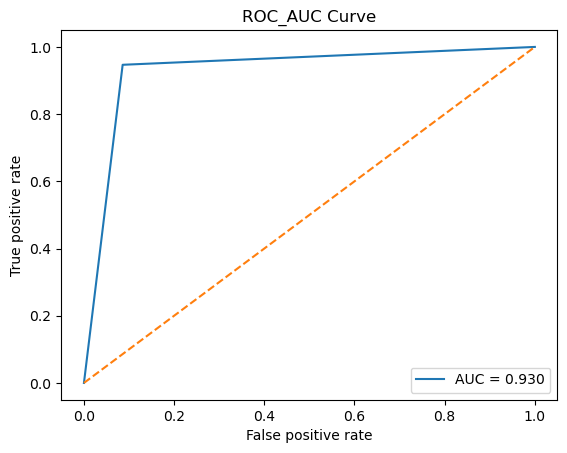

In [33]:
#Evaluate the model by ROC-Curve
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], '--')
plt.title('ROC_AUC Curve')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [34]:
#Loading Dataset - Test Data
test_df = pd.read_parquet('test.parquet')

In [35]:
#Analysis of Data
#Checking the size of the dataset
print("Data set size:", test_df.shape)

Data set size: (1065524, 3)


In [36]:
test_df.head()

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0


In [37]:
test_df.tail()

,Patient-Uid,Date,Incident
1372854,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-11,DRUG_TYPE_13
1372856,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2018-08-22,DRUG_TYPE_2
1372857,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-02-04,DRUG_TYPE_2
1372858,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-09-25,DRUG_TYPE_8
1372859,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-19,DRUG_TYPE_7


In [38]:
#Columns in the dataset
test_df.columns

Index(['Patient-Uid', 'Date', 'Incident'], dtype='object')

In [39]:
#Descriptive statistics
test_df.describe()

,Date
count,1065524
mean,2017-09-01 15:54:13.488799488
min,2015-04-07 00:00:00
25%,2016-07-26 00:00:00
50%,2017-09-11 00:00:00
75%,2018-09-26 00:00:00
max,2020-08-04 00:00:00


In [40]:
#Data Cleaning - Missing Values
test_df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [41]:
#Finding Duplicate Values
test_df.duplicated().sum()

12100

In [42]:
#Remove duplicates
test_df = test_df.drop_duplicates()

In [43]:
#Checking for duplicate values
test_df.duplicated().sum()

0

In [44]:
#Data Types
test_df.dtypes

Patient-Uid            object
Date           datetime64[ns]
Incident               object
dtype: object

In [45]:
#Unique values of Incident
print("Unique values of Incident \n")
print(test_df['Incident'].unique())

Unique values of Incident 

['SYMPTOM_TYPE_0' 'DRUG_TYPE_0' 'DRUG_TYPE_2' 'DRUG_TYPE_1'
 'PRIMARY_DIAGNOSIS' 'DRUG_TYPE_8' 'TEST_TYPE_0' 'DRUG_TYPE_7'
 'DRUG_TYPE_11' 'SYMPTOM_TYPE_6' 'DRUG_TYPE_5' 'DRUG_TYPE_6' 'DRUG_TYPE_9'
 'DRUG_TYPE_15' 'TEST_TYPE_3' 'SYMPTOM_TYPE_3' 'TEST_TYPE_1' 'DRUG_TYPE_3'
 'TEST_TYPE_2' 'SYMPTOM_TYPE_7' 'DRUG_TYPE_12' 'SYMPTOM_TYPE_2'
 'SYMPTOM_TYPE_10' 'SYMPTOM_TYPE_1' 'SYMPTOM_TYPE_17' 'SYMPTOM_TYPE_18'
 'SYMPTOM_TYPE_5' 'SYMPTOM_TYPE_15' 'SYMPTOM_TYPE_9' 'SYMPTOM_TYPE_4'
 'SYMPTOM_TYPE_8' 'SYMPTOM_TYPE_29' 'DRUG_TYPE_13' 'SYMPTOM_TYPE_21'
 'DRUG_TYPE_4' 'SYMPTOM_TYPE_12' 'SYMPTOM_TYPE_11' 'SYMPTOM_TYPE_19'
 'DRUG_TYPE_14' 'SYMPTOM_TYPE_16' 'TEST_TYPE_4' 'DRUG_TYPE_10'
 'SYMPTOM_TYPE_26' 'SYMPTOM_TYPE_14' 'SYMPTOM_TYPE_24' 'DRUG_TYPE_16'
 'SYMPTOM_TYPE_13' 'TEST_TYPE_5' 'SYMPTOM_TYPE_20' 'SYMPTOM_TYPE_25'
 'SYMPTOM_TYPE_22' 'DRUG_TYPE_17' 'SYMPTOM_TYPE_27' 'SYMPTOM_TYPE_23'
 'SYMPTOM_TYPE_28']


In [46]:
#Exploring the dataset
#Counts for each Incident
test_df.Incident.value_counts()

Incident
DRUG_TYPE_6          188401
DRUG_TYPE_1          169089
PRIMARY_DIAGNOSIS    127996
DRUG_TYPE_0           90711
DRUG_TYPE_2           90465
DRUG_TYPE_7           90423
DRUG_TYPE_8           55696
DRUG_TYPE_3           40679
TEST_TYPE_1           34274
DRUG_TYPE_9           25294
DRUG_TYPE_5           20045
SYMPTOM_TYPE_0        17292
DRUG_TYPE_11          16587
SYMPTOM_TYPE_6        11536
TEST_TYPE_0           10921
SYMPTOM_TYPE_7         7943
SYMPTOM_TYPE_5         5403
DRUG_TYPE_14           4963
DRUG_TYPE_10           4242
DRUG_TYPE_13           4059
SYMPTOM_TYPE_1         2955
DRUG_TYPE_12           2823
SYMPTOM_TYPE_2         2772
TEST_TYPE_3            2709
SYMPTOM_TYPE_8         2683
TEST_TYPE_2            2524
SYMPTOM_TYPE_14        2482
DRUG_TYPE_4            1840
SYMPTOM_TYPE_15        1818
SYMPTOM_TYPE_10        1783
SYMPTOM_TYPE_29        1697
SYMPTOM_TYPE_9         1689
SYMPTOM_TYPE_16        1576
DRUG_TYPE_15           1373
SYMPTOM_TYPE_4         1315
SYMPTOM_TYP

In [47]:
#Generate the positive set
positive_df = test_df[test_df['Incident'] == 'TARGET DRUG']
positive_df.head()

,Patient-Uid,Date,Incident


In [48]:
#Shape of positive set
positive_df.shape

(0, 3)

In [49]:
#Generate the negative set
negative = test_df[~test_df['Patient-Uid'].isin(positive_df['Patient-Uid'])]
negative_df = negative.groupby('Patient-Uid').tail(1)
negative_df

,Patient-Uid,Date,Incident
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6
...,...,...,...
1372381,a102720c-1c7c-11ec-bd9a-16262ee38c7f,2020-01-07,DRUG_TYPE_6
1372432,a102723c-1c7c-11ec-9f80-16262ee38c7f,2019-07-06,DRUG_TYPE_3
1372543,a102726b-1c7c-11ec-bfbf-16262ee38c7f,2018-12-31,DRUG_TYPE_0
1372607,a102729b-1c7c-11ec-86ba-16262ee38c7f,2019-04-02,DRUG_TYPE_3


In [50]:
#Shape of the negative set
negative_df.shape

(11482, 3)

In [51]:
#Calculate prescription counts within specific time intervals
positive_df['Prescription_Count'] = positive_df.groupby('Patient-Uid')['Date'].cumcount()
negative_df['Prescription_Count'] = negative_df.groupby('Patient-Uid')['Date'].cumcount()
positive_df.tail(5)

,Patient-Uid,Date,Incident,Prescription_Count


In [52]:
negative_df.tail()

,Patient-Uid,Date,Incident,Prescription_Count
1372381,a102720c-1c7c-11ec-bd9a-16262ee38c7f,2020-01-07,DRUG_TYPE_6,0
1372432,a102723c-1c7c-11ec-9f80-16262ee38c7f,2019-07-06,DRUG_TYPE_3,0
1372543,a102726b-1c7c-11ec-bfbf-16262ee38c7f,2018-12-31,DRUG_TYPE_0,0
1372607,a102729b-1c7c-11ec-86ba-16262ee38c7f,2019-04-02,DRUG_TYPE_3,0
1372859,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-19,DRUG_TYPE_7,0


In [53]:
#Calculate the difference between the most recent prescription and the prediction date
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_df['Time_diff'] = (prediction_date - positive_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_df['Time_diff'] = (prediction_date - negative_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [54]:
positive_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff


In [55]:
#Create a new dataset by concatenating positive and negative sets
new_df = pd.concat([positive_df, negative_df])
new_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0,0,2184
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9,0,2711
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6,0,1587
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6,0,2718
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6,0,1828


In [56]:
new_df.shape

(11482, 5)

In [57]:
#Verify the column names in the DataFrame
print(test_df.columns)

Index(['Patient-Uid', 'Date', 'Incident'], dtype='object')


In [58]:
train_df.drop_duplicates(inplace=True)

In [59]:
#Assuming you have X_train and y_train as your training data
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
#Assuming the test data is loaded into test_df as shown earlier

#Calculate Prescription Count for test data
test_df['Prescription_Count'] = test_df.groupby('Patient-Uid')['Date'].cumcount()

In [61]:
#Calculate Time Difference for test data
test_df['Time_diff'] = (prediction_date - test_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [62]:
#Select the features for prediction
X_submission = test_df[['Prescription_Count', 'Time_diff']]

In [63]:
#Make predictions on the test data
submission_predictions = xgb_classifier.predict(X_submission)

In [64]:
#Create a DataFrame for the final submission
final_submission_df = test_df[['Patient-Uid', 'Date', 'Incident']].copy()
final_submission_df['Prediction'] = submission_predictions.astype(int)

In [65]:
#Save the final submission DataFrame to a CSV file
final_submission_df.to_csv('final_submission.csv', index=False)

### ___THE END___